# **Implement BERT**
paper: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

![](https://paul-hyun.github.io/assets/2020-01-02/bert-pretrain.png)

In [1]:
!pip install sentencepiece
!pip install wget

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Data/ML tutorial'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import math
from random import random, randrange, randint, shuffle, choice
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
for f in os.listdir(data_dir):
  print(f)

kowiki.txt
kowiki.model
kowiki.vocab
ratings_train.txt
ratings_test.txt
ratings_train.json
ratings_test.json


In [5]:
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

Set Config

In [6]:
class Config(dict):
  __getattr__ = dict.__getitem__
  __setattr__ = dict.__setitem__

  @classmethod
  def load(cls, file):
    with open(file, 'r') as f:
      config = json.loads(f.read())
      return Config(config)

In [7]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_seg_type": 2,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


## Implement BERT using codes from [Transformer-02](https://github.com/ionheart26/Machine-Learning-tutorial/blob/master/Transformer-02.ipynb)

In [8]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

def get_attn_pad_mask(seq_q, seq_k, i_pad):
      batch_size, len_q = seq_q.size()
      batch_size, len_k = seq_k.size()
      pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)
      return pad_attn_mask

def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
  subsequent_mask = subsequent_mask.triu(diagonal=1)
  return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

In [10]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        self.pos_emb = nn.Embedding(self.config.n_enc_seq + 1, self.config.d_hidn)
        self.seg_emb = nn.Embedding(self.config.n_seg_type, self.config.d_hidn)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs, segments):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)  + self.seg_emb(segments)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

In [11]:
class BERT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)

        self.linear = nn.Linear(config.d_hidn, config.d_hidn)
        self.activation = torch.tanh
    
    def forward(self, inputs, segments):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, self_attn_probs = self.encoder(inputs, segments)
        # (bs, d_hidn)
        outputs_cls = outputs[:, 0].contiguous()
        outputs_cls = self.linear(outputs_cls)
        outputs_cls = self.activation(outputs_cls)
        # (bs, n_enc_seq, n_enc_vocab), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, outputs_cls, self_attn_probs
    
    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

## Pretrain Bert
![](https://paul-hyun.github.io/assets/2020-01-02/bert-mlm-nsp.png)

In [12]:
class BERTPretrain(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.bert = BERT(self.config)
        # classfier
        self.projection_cls = nn.Linear(self.config.d_hidn, 2, bias=False)
        # lm
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_enc_vocab, bias=False)
        self.projection_lm.weight = self.bert.encoder.enc_emb.weight
    
    def forward(self, inputs, segments):
        # (bs, n_enc_seq, d_hidn), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, outputs_cls, attn_probs = self.bert(inputs, segments)
        # (bs, 2)
        logits_cls = self.projection_cls(outputs_cls)
        # (bs, n_enc_seq, n_enc_vocab)
        logits_lm = self.projection_lm(outputs)
        # (bs, n_enc_vocab), (bs, n_enc_seq, n_enc_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return logits_cls, logits_lm, attn_probs

Make Pretrain data

In [13]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    '''
    Create pretrain mask for MLM
    tokens: a list of tokens, where each tokens are string type
    '''
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        for index in index_set:
            masked_token = None
            if random() < 0.8: # 80% replace with [MASK]
                masked_token = "[MASK]"
            else:
                if random() < 0.5: # 10% keep original
                    masked_token = tokens[index]
                else: # 10% random word
                    masked_token = choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [14]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [15]:
def create_pretrain_instances(docs, doc_idx, doc, n_seq, mask_prob, vocab_list):
    '''
    Create pretrain instances for MLM and NSP.
    doc: a single document which is a list of lines, where each lines are list of tokens, and each tokens are string type.
    '''
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3
    tgt_seq = max_seq
    
    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i]) # line
        current_length += len(doc[i])
        if i == len(doc) - 1 or current_length >= tgt_seq:
            if 0 < len(current_chunk):
                a_end = 1 # index after token a
                if 1 < len(current_chunk):
                    a_end = randrange(1, len(current_chunk))
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                
                tokens_b = []
                # make token b from random doc
                if len(current_chunk) == 1 or random() < 0.5:
                    is_next = 0
                    tokens_b_len = tgt_seq - len(tokens_a)
                    random_doc_idx = doc_idx
                    while doc_idx == random_doc_idx:
                        random_doc_idx = randrange(0, len(docs))
                    random_doc = docs[random_doc_idx]

                    random_start = randrange(0, len(random_doc))
                    for j in range(random_start, len(random_doc)):
                        tokens_b.extend(random_doc[j])
                # make token b from next part of token a
                else:
                    is_next = 1
                    for j in range(a_end, len(current_chunk)):
                        tokens_b.extend(current_chunk[j])

                trim_tokens(tokens_a, tokens_b, max_seq)
                assert 0 < len(tokens_a)
                assert 0 < len(tokens_b)

                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [16]:
def make_pretrain_data(vocab, in_file, out_file, count, n_seq, mask_prob):
    vocab_list = []
    for id in range(vocab.get_piece_size()):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1
    
    docs = []
    with open(in_file, "r") as f:
        doc = []
        with tqdm_notebook(total=line_cnt, desc=f"Loading") as pbar:
            for i, line in enumerate(f):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        docs.append(doc)
                        doc = []
                        # 메모리 사용량을 줄이기 위해 100,000개만 처리 함
                        if 100000 < len(docs): break
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
                pbar.update(1)
        if doc:
            docs.append(doc)

    for index in range(count):
        output = out_file.format(index)
        if os.path.isfile(output): continue

        with open(output, "w") as out_f:
            with tqdm_notebook(total=len(docs), desc=f"Making") as pbar:
                for i, doc in enumerate(docs):
                    instances = create_pretrain_instances(docs, i, doc, n_seq, mask_prob, vocab_list)
                    for instance in instances:
                        out_f.write(json.dumps(instance))
                        out_f.write("\n")
                    pbar.update(1)

In [17]:
in_file = f"{data_dir}/kowiki.txt"
out_file = f"{data_dir}/kowiki_bert" + "_{}.json"
count = 1
n_seq = 256
mask_prob = 0.15

make_pretrain_data(vocab, in_file, out_file, count, n_seq, mask_prob)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Make Pretrain Dataset

In [18]:
class PretrainDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels_cls = []
        self.labels_lm = []
        self.sentences = []
        self.segments = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                instance = json.loads(line)
                self.labels_cls.append(instance["is_next"])
                sentences = [vocab.piece_to_id(p) for p in instance["tokens"]]
                self.sentences.append(sentences)
                self.segments.append(instance["segment"])
                mask_idx = np.array(instance["mask_idx"], dtype=np.int)
                mask_label = np.array([vocab.piece_to_id(p) for p in instance["mask_label"]], dtype=np.int)
                label_lm = np.full(len(sentences), dtype=np.int, fill_value=-1)
                label_lm[mask_idx] = mask_label
                self.labels_lm.append(label_lm)
    
    def __len__(self):
        assert len(self.labels_cls) == len(self.labels_lm)
        assert len(self.labels_cls) == len(self.sentences)
        assert len(self.labels_cls) == len(self.segments)
        return len(self.labels_cls)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels_cls[item]),
                torch.tensor(self.labels_lm[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor(self.segments[item]))

In [19]:
def pretrin_collate_fn(inputs):
    labels_cls, labels_lm, inputs, segments = list(zip(*inputs))

    labels_lm = torch.nn.utils.rnn.pad_sequence(labels_lm, batch_first=True, padding_value=-1)
    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels_cls, dim=0),
        labels_lm,
        inputs,
        segments
    ]
    return batch

In [20]:
batch_size = 128
dataset = PretrainDataSet(vocab, f"{data_dir}/kowiki_bert_0.json")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

Loading /content/drive/My Drive/Data/ML tutorial/kowiki_bert_0.json: 100%|██████████| 239857/239857 [01:23<00:00, 2863.71 lines/s]


Pretrain

In [21]:
def train_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            labels_cls, labels_lm, inputs, segments = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(inputs, segments)
            logits_cls, logits_lm = outputs[0], outputs[1]

            loss_cls = criterion_cls(logits_cls, labels_cls)
            loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(2)), labels_lm.view(-1))
            loss = loss_cls + loss_lm

            loss_val = loss_lm.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [22]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(config)

learning_rate = 5e-5
n_epoch = 20

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda')}


In [ ]:
model = BERTPretrain(config)

save_pretrain = f"{data_dir}/save_bert_pretrain.pth"
best_epoch, best_loss = 0, 0
if os.path.isfile(save_pretrain):
    best_epoch, best_loss = model.bert.load(save_pretrain)
    print(f"load pretrain from: {save_pretrain}, epoch={best_epoch}, loss={best_loss}")
    best_epoch += 1

model.to(config.device)

criterion_lm = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
criterion_cls = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
offset = best_epoch
for step in range(n_epoch):
    epoch = step + offset
    if 0 < step:
        del train_loader
        dataset = PretrainDataSet(vocab, f"{data_dir}/kowiki_bert_{epoch % count}.json")
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

    loss = train_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, train_loader)
    losses.append(loss)
    model.bert.save(epoch, loss, save_pretrain)

,loss
0,18.027608
1,8.801137
2,7.325305
3,7.015369
4,6.909906
5,6.861085
6,6.828222
7,6.804363
8,6.788513
9,6.774536


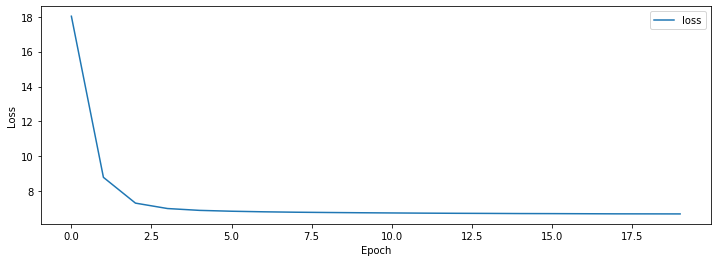

In [ ]:
# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()